In [ ]:
! pip install transformers

In [ ]:
! pip install conllu

# Classifying Tweets from the Financial Market Domain with Predicate Names

Our goal is, given a tweet in portuguese from the financial market domain, to classify whether or not this tweet contains a predicate name.

## Packages

In [ ]:
import numpy as np
import pandas as pd
import conllu as c
import torch
import matplotlib.pyplot as plt

## Data

In [ ]:
npreds = pd.read_csv('npreds_emot.csv')
corpus_sem_preds = pd.read_csv('dante_nonpreds.csv')

In [ ]:
npreds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1401 entries, 0 to 1400
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    1401 non-null   int64  
 1   tweet_ids     1401 non-null   object 
 2   text_x        1401 non-null   object 
 3   TRU           1401 non-null   int64  
 4   DIS           1401 non-null   int64  
 5   JOY           1401 non-null   int64  
 6   SAD           1401 non-null   int64  
 7   ANT           1401 non-null   int64  
 8   SUR           1401 non-null   int64  
 9   ANG           1401 non-null   int64  
 10  FEA           1401 non-null   int64  
 11  NEUTRAL       1401 non-null   int64  
 12  conf_tru_dis  1401 non-null   float64
 13  conf_joy_sad  1401 non-null   float64
 14  conf_ant_sur  1401 non-null   float64
 15  conf_ang_fea  1401 non-null   float64
 16  num_annot     1401 non-null   int64  
dtypes: float64(4), int64(11), object(2)
memory usage: 186.2+ KB


In [ ]:
# conjunto de todos os tweets
dante_npreds_conllu = open('tweets_npreds.conllu', "r", encoding="utf-8")
dante_npreds_parsed = dante_npreds_conllu.read()
dante_npreds_conllu.close()
dante_npreds_parsed = c.parse(dante_npreds_parsed)

dante_npreds = {'tweet_ids': [], 'text': []}

for i in range(len(dante_npreds_parsed)):
  dante_npreds['tweet_ids'].append(dante_npreds_parsed[i].metadata['sent_id'].split('01_')[1])
  dante_npreds['text'].append(dante_npreds_parsed[i].metadata['text'].strip())

In [ ]:
dante_npreds = pd.DataFrame(dante_npreds)

In [ ]:
# conjunto de todos os tweets para a versao mais atualizada do dante stocks
data = open('DANTEStocks (15dez2022).conllu', "r", encoding="utf-8")
annotations = data.read()
data.close()
sentences = c.parse(annotations)

In [ ]:
dante_stocks = {'tweet_ids':[], 'text':[]}
for i in range(len(sentences)):
  dante_stocks['tweet_ids'].append(sentences[i].metadata['sent_id'].split('_01_')[1])
  dante_stocks['text'].append(sentences[i].metadata['text'].strip())

In [ ]:
dante_stocks = pd.DataFrame(dante_stocks)

In [ ]:
dante_stocks.head()

,tweet_ids,text
0,441014389496619009l,#VALE5 - Análise #Ichimoku - pregão de sexta-f...
1,441020223408578560l,#PETR4 - Análise #Ichimoku - pregão de sexta-f...
2,441028254942502912l,as nuvens do ichimoku: PETR4 - pregão de sexta...
3,441030534467055617l,Em a #PETR4 fizemos em a sexta passada uma Sub...
4,441032165967814656l,@PaiRico @frfontanella @eddu56 @TiagoBDS Acabe...


In [ ]:
rows_to_drop = [i for i in range(dante_stocks.shape[0]) if dante_stocks.tweet_ids.to_list()[i] not in corpus_sem_preds.tweet_id.to_list()]

In [ ]:
dante_stocks.drop(rows_to_drop, axis=0, inplace=True)
dante_stocks = dante_stocks.text.to_list()

In [ ]:
print(len(dante_stocks))
print(len(npreds))
print(len(dante_stocks) + len(npreds))

2647
1401
4048


## Creating Dataframes for Classification

In [ ]:
npreds_with_target = pd.DataFrame({'text':npreds['text_x'],
                                   'target':np.ones(npreds.shape[0])})

In [ ]:
dante_with_target = pd.DataFrame({'text':dante_stocks,
                                  'target':np.zeros(len(dante_stocks))})

In [ ]:
data = pd.concat((npreds_with_target, dante_with_target))

In [ ]:
data = data.sample(frac=1, random_state=1234)

In [ ]:
data.reset_index(inplace=True, drop=True)

<Axes: xlabel='target'>

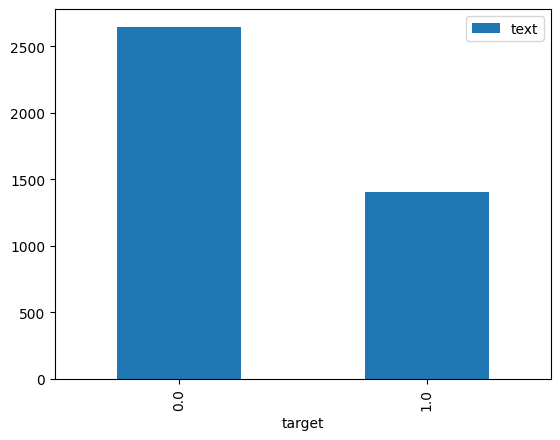

In [ ]:
# very unbalanced
data.groupby('target').count().plot.bar()

In [ ]:
data

,text,target
0,#MRFG3 - Análise #Ichimoku - Recomendação de C...,1.0
1,RT @RaphaFigueredo: *** SAIU DO FORNO: RUI FAL...,1.0
2,"@Live_Trade não, ainda tem a #PETR4 ... ,) hehehe",0.0
3,$CYRE3 - Cyrela Realt (cyre-nm) - Demonstracoe...,0.0
4,@abilio_diniz @paodeacucar Análise dos fundam...,0.0
...,...,...
4043,"ELET3 bateu no objetivo do Anderson agora,quer...",0.0
4044,Rastreamento ações-Gráfico diário-11h. Analise...,0.0
4045,A última indicação da #JBSS3 resultou em -4.21...,1.0
4046,#LLXL3 minha opiniao é que é mto fundo zerando...,1.0


## Train-Test Split

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X = data.text.to_numpy()
y = data.target.to_numpy()

In [ ]:
train_d, test_d, y_train, y_test = train_test_split(X, y,
                                                test_size=0.2,
                                                shuffle=True,
                                                random_state=0, # trocar semente
                                                stratify=y)

In [ ]:
train_d

array(['GGBR4 vender por R$ 17,84 indicado em 03/01/2014 15:26 http://t.co/zJRs3Eeyz9',
       'Quebra de sigilo bancário da #PETR4.. E foi aberta a caixa de PANDORA!!',
       'A última indicação de a #ITUB4 resultou em 0.84 %. Confira a nova indicação agora em http://t.co/zJRs3Eeyz9',
       ...,
       'Estatais em alta: Petrobrás ordinárias, +6,82%, Preferenciais, +6,45%, B.do Brasil, +6,96%, Elet3 +8,46% e Eletr 6, +4,78%',
       'Rastreamento ações - Gráfico MENSAL - 11h . Analise se romper : ITUB3 31,77 LAME4 16,85 MDIA3 92,20 PTBL3 5,04 PFRM3 21,53 RADL3 19,13 SMTO3 31,18',
       '@clubedopairico #PETR4 com muitos processos la fora sobre lavagem de dinheiro...mas pouco divulgado aqui...pq será? rsrs'],
      dtype=object)

In [ ]:
# test_d, val_d, y_test, y_val = train_test_split(test_d, y_test,
#                                                 test_size=0.5,
#                                                 random_state=0)

In [ ]:
np.unique(y_train, return_counts=True)

(array([0., 1.]), array([2117, 1121]))

In [ ]:
np.unique(y_test, return_counts=True)

(array([0., 1.]), array([530, 280]))

In [ ]:
# np.unique(y_val, return_counts=True)

## Preprocessing

In order to tokenize the data so as to create embeddings of the tokens, we must first remove punctuations, special characters and URLs that are prevelant in our data.

In [ ]:
import re
import string

In [ ]:
def clean_text(text):

    # lower case
    text = text.lower()

    # removes the type of URL we see in our data
    text = re.sub('http://t\.co/[A-Za-z0-9]+', '', text)

    # removes r$
    text = re.sub('[rR]\$', '', text)

    # removes any HTML text
    text = re.sub('<.*?>+', '', text)

    # # substitutes decimal numbers to placeholder
    text = re.sub(r'\b\d+\.\d+\b', ' valordecimal ', text)
    text = re.sub(r'\b\d+\,\d+\b', ' valordecimal ', text)

    # removes punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)

    # removes spaces
    text = re.sub('\n', '', text)

    # substitutes tickers to placeholder
    # text = re.sub('\s*(\$|#)[a-zA-Z]{4}\d+\s*', ' stktkr ', text)
    # text = re.sub('\s*[a-zA-Z]{4}\d+\s*', ' stktkr ', text)

    # substitutes rt for retweet, q for que and c for com
    text = re.sub('\s*(rt)\s+', ' retweet ', text)
    text = re.sub('\s*(q)\s+', ' que ', text)
    text = re.sub('\s*(c)\s+', ' com ', text)

    # substitutes multiple spaces to one space
    text = re.sub('\s+', ' ', text)

    text = text.strip()

    return text

In [ ]:
ct_train = [clean_text(t) for t in train_d]
ct_test = [clean_text(t) for t in test_d]

## Tokenizing and Dataloader

In [ ]:
from transformers import AutoTokenizer
from torch.utils.data import Dataset, DataLoader

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('neuralmind/bert-base-portuguese-cased', do_lower_case=False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/210k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
# checking maximum sentence size
max_length=-10
for t in train_d:
  t_size = len(t.split(' '))
  if t_size > max_length:
    max_length = t_size

max_length

42

In [ ]:
def tok_func(text):
  return tokenizer(text,
                   padding='max_length',
                   max_length=128,
                   return_tensors='pt',
                   truncation=True)

In [ ]:
class NpredDataset(Dataset):

  def __init__(self, text, labels):

    self.text = text
    self.labels = labels
    #self.tok = tokenizer

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):

    encoded_text = tok_func(self.text[idx])

    item = {'input_ids':encoded_text['input_ids'],
            'attention_mask':encoded_text['attention_mask'],
            'labels':self.labels[idx]}
    return item

In [ ]:
train_ds = NpredDataset(train_d, y_train)

In [ ]:
test_ds = NpredDataset(test_d, y_test)

In [ ]:
# val_ds = NpredDataset(val_d, y_val)

In [ ]:
# train size is prime so we will set a batch size that
# will not divide it equally
batch_size = 16

train_dlr = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dlr = DataLoader(test_ds, batch_size=batch_size, shuffle=True)
# val_dlr = DataLoader(val_ds, batch_size=batch_size, shuffle=True)

## Model

In [ ]:
from transformers import AutoModel
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class NpredModel(nn.Module):

  def __init__(self, n_labels):
    super(NpredModel, self).__init__()

    self.n_labels = n_labels

    # BERTimbau model
    self.bert = AutoModel.from_pretrained('neuralmind/bert-base-portuguese-cased')

    # regularization to avoid overfitting
    self.dropout = nn.Dropout(0.3)

    # classification layer
    self.linear = nn.Linear(self.bert.config.hidden_size, self.n_labels)

    # sigmoid activation function
    self.sigmoid = nn.Sigmoid()

  def forward(self, input_ids, attention_mask):

    # get encodings
    encod = self.bert(input_ids=input_ids, attention_mask=attention_mask)
    pooled_encod = encod.pooler_output

    # apply regularization
    x = self.dropout(pooled_encod)

    # get output
    logits = self.linear(x)

    logits = self.sigmoid(logits)

    return logits

In [ ]:
a = NpredModel(1)
a.forward(input_ids=train_ds[0]['input_ids'],
          attention_mask=train_ds[0]['attention_mask'])

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tensor([[0.5074]], grad_fn=<SigmoidBackward0>)

## Evaluation Function

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
def evaluate(m, dtlr, loss):


    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    m.eval()
    val_running_loss = 0
    predictions = []
    actual_labels = []

    for batch in dtlr:

      # get input ids and attention mask
      input_ids = torch.squeeze(batch['input_ids']).to(device)
      attention_mask = torch.squeeze(batch['attention_mask']).to(device)
      label = batch['labels'].reshape(-1, 1)
      label = label.type(torch.float32).to(device)

      # forward
      output = m(input_ids, attention_mask=attention_mask)

      # get loss
      l = loss(output, label)

      # update running loss
      val_running_loss += l.item()

      # update metrics
      ypred = torch.round(output)
      predictions.extend(ypred.cpu().detach().numpy())
      actual_labels.extend(label.cpu().detach().numpy())

    acc = accuracy_score(actual_labels, predictions)
    class_rep = classification_report(actual_labels, predictions, labels=[0,1], output_dict=True)
    valid_loss = val_running_loss / len(dtlr)
    print('Validation Loss: ', valid_loss,
          'Validation Accuracy Score: ', acc, '\n',
          'Classification Report: ', class_rep)

    return valid_loss, class_rep

## Train

In [ ]:
def train(m, dlrt, lr, loss):

  optm = torch.optim.AdamW(m.parameters(), lr=lr)
  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

  m.to(device)
  predictions = []
  actual_labels = []

  m.train()
  train_running_loss = 0

  for i, batch in enumerate(dlrt):

    if (i % 10 == 0) or (i == len(dlrt)):
      print('Batch: ', i, '/', len(dlrt))

    # zero the gradient
    optm.zero_grad()

    # get input ids and attention mask
    input_ids = batch['input_ids'].squeeze(1).to(device)
    attention_mask = batch['attention_mask'].squeeze(1).to(device)
    label = batch['labels'].reshape(-1, 1)
    label = label.type(torch.float32).to(device)


    # forward
    output = m(input_ids, attention_mask)
    ypred = torch.round(output)
    predictions.extend(ypred.cpu().detach().numpy())
    actual_labels.extend(label.cpu().detach().numpy())

    # print(output.shape)
    # print(label.shape)

    # get loss
    l = loss(output, label)

    # backpropagate
    l.backward()

    # step
    optm.step()

    # update running loss
    train_running_loss += l.item()

  print('Finished Batch: ')

  acc = accuracy_score(actual_labels, predictions)
  epoch_loss = train_running_loss / len(dlrt)

  print('Training Loss: ', epoch_loss,
        'Training Accuracy Score: ', acc)

  return epoch_loss

## Running Training and Evaluation

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
loss = nn.BCELoss()

In [ ]:
max_epochs = 5

In [ ]:
lr = 2e-7

In [ ]:
model = NpredModel(1)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
train_losses = []
val_losses = []

In [ ]:
# defining early stopping variables
patience = 2
min_val_loss = np.inf
min_delta = 5

In [ ]:
# print('##############################', '\n')
# print('#            START           #', '\n')
# print('##############################')
# for e in range(max_epochs):
#   print('Epoch: ', e, '\n')
#   train_loss = train(model, train_dlr, lr, loss)
#   train_losses.append(train_loss)
#   val_loss, class_rep = evaluate(model, val_dlr, loss)
#   val_losses.append(val_loss)

#   # early stopping
#   if val_loss < min_val_loss:
#     min_val_loss = val_loss
#     name = 'model_epoch_' + str(e) + '.pt'
#     torch.save(model.state_dict(), 'model.pt')
#     patience = 2
#   elif val_loss > (min_val_loss + min_delta):
#     patience -= 1
#     if patience == 0:
#       break
# print('##############################', '\n')
# print('#             END            #', '\n')
# print('##############################')

In [ ]:
# plt.plot(train_losses, label='train')
# plt.plot(val_losses, label='val')
# plt.legend()
# plt.show()

## Training with Stratified KFold

In [ ]:
from sklearn.model_selection import StratifiedKFold
from google.colab import files

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def train_and_eval_with_kfold(X, y, loss, me, min_delta, k=10, lr=2e-7, random_state=0, patience=2):

  # declaring random seed
  torch.manual_seed(random_state)

  # declare kfold
  skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=random_state)

  # declaring device
  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

  train_losses = {}
  val_losses = {}
  classification_reports = {}
  best_model_weights = {}

  for i, (train_index, val_index) in enumerate(skf.split(X, y)):

    train_index = train_index.astype(int)
    val_index = val_index.astype(int)

    print(f'Fold: {i}')

    # creating data based on fold
    train_d, test_d = X[train_index], X[val_index]
    y_train, y_test = y[train_index], y[val_index]

    # saving data
    name_xtrain = 'xtrain_data_fold_' + str(i) + '_random_state_' + str(random_state) + '.txt'
    name_xtest = 'xval_data_fold_' + str(i) + '_random_state_' + str(random_state) + '.txt'
    name_ytrain = 'ytrain_data_fold_' + str(i) + '_random_state_' + str(random_state) + '.txt'
    name_ytest = 'yval_data_fold_' + str(i) + '_random_state_' + str(random_state) + '.txt'
    np.savetxt("results/" + name_xtrain, train_d, fmt='%s')
    np.savetxt("results/" + name_xtest, test_d, fmt='%s')
    np.savetxt("results/" + name_ytrain, y_train, fmt='%i')
    np.savetxt("results/" + name_ytest, y_test, fmt='%i')

    # creating dataloader
    train_ds = NpredDataset(train_d, y_train)
    test_ds = NpredDataset(test_d, y_test)
    train_dlr = DataLoader(train_ds, batch_size=16, shuffle=True)
    test_dlr = DataLoader(test_ds, batch_size=16, shuffle=True)

    # declaring the model
    m = NpredModel(1)
    m.to(device)
    fold_train_losses = []
    fold_val_losses = []
    fold_class_rep = []

    # declaring important variables
    max_epochs = 100
    min_val_loss = np.inf
    best_model = None
    patience = 2


    for e in range(max_epochs):
      print('Epoch: ', e, '\n')
      train_loss = train(m, train_dlr, lr, loss)
      fold_train_losses.append(train_loss)
      val_loss, class_rep = evaluate(m, test_dlr, loss)
      fold_val_losses.append(val_loss)
      fold_class_rep.append(class_rep)

      # early stopping
      if val_loss < min_val_loss:

        # update lowest validation loss
        min_val_loss = val_loss

        # saving best model parameters
        best_model = m.state_dict()

        # reestablish patience
        patience = patience

      elif val_loss > (min_val_loss + min_delta):

        patience -= 1

        # save best model
        if patience == 0:
          name = 'results/model_fold_' + str(i) + '_epoch_' + str(e) + '_random_state' + str(random_state) + '.pth'
          torch.save(best_model, name)
          # files.download(name)
          break

    train_losses[i] = fold_train_losses
    val_losses[i] = fold_val_losses
    classification_reports[i] = fold_class_rep
    best_model_weights[i] = best_model

  return train_losses, val_losses, classification_reports, best_model_weights

In [ ]:
loss = nn.BCELoss()

In [ ]:
me = 200

In [ ]:
min_delta = 0.001

In [ ]:
train_losses, val_losses, precision_scores, recall_scores, f1_scores, class_reps, m_weights = train_and_eval_with_kfold(train_d, y_train, loss, me, min_delta, lr=1e-5)

Fold: 0
Epoch:  0 

Batch:  0 / 183
Batch:  10 / 183
Batch:  20 / 183
Batch:  30 / 183
Batch:  40 / 183
Batch:  50 / 183
Batch:  60 / 183
Batch:  70 / 183
Batch:  80 / 183
Batch:  90 / 183
Batch:  100 / 183
Batch:  110 / 183
Batch:  120 / 183
Batch:  130 / 183
Batch:  140 / 183
Batch:  150 / 183
Batch:  160 / 183
Batch:  170 / 183
Batch:  180 / 183
Finished Batch: 
Training Loss:  0.5392193554447648 Training Accuracy Score:  0.7220315717227179
Validation Loss:  0.39937816595747355 Validation Accuracy Score:  0.8055555555555556 
 Classification Report:  {'0': {'precision': 0.7854406130268199, 'recall': 0.9669811320754716, 'f1-score': 0.8668076109936576, 'support': 212}, '1': {'precision': 0.8888888888888888, 'recall': 0.5, 'f1-score': 0.64, 'support': 112}, 'accuracy': 0.8055555555555556, 'macro avg': {'precision': 0.8371647509578544, 'recall': 0.7334905660377358, 'f1-score': 0.7534038054968288, 'support': 324}, 'weighted avg': {'precision': 0.8212005108556834, 'recall': 0.8055555555555

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Fold: 1
Epoch:  0 

Batch:  0 / 183
Batch:  10 / 183
Batch:  20 / 183
Batch:  30 / 183
Batch:  40 / 183
Batch:  50 / 183
Batch:  60 / 183
Batch:  70 / 183
Batch:  80 / 183
Batch:  90 / 183
Batch:  100 / 183
Batch:  110 / 183
Batch:  120 / 183
Batch:  130 / 183
Batch:  140 / 183
Batch:  150 / 183
Batch:  160 / 183
Batch:  170 / 183
Batch:  180 / 183
Finished Batch: 
Training Loss:  0.5946708762906289 Training Accuracy Score:  0.6870281400137268
Validation Loss:  0.4858483047712417 Validation Accuracy Score:  0.7438271604938271 
 Classification Report:  {'0': {'precision': 0.7279151943462897, 'recall': 0.9716981132075472, 'f1-score': 0.8323232323232322, 'support': 212}, '1': {'precision': 0.8536585365853658, 'recall': 0.3125, 'f1-score': 0.45751633986928114, 'support': 112}, 'accuracy': 0.7438271604938271, 'macro avg': {'precision': 0.7907868654658278, 'recall': 0.6420990566037736, 'f1-score': 0.6449197860962567, 'support': 324}, 'weighted avg': {'precision': 0.7713820287005382, 'recall'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Fold: 2
Epoch:  0 

Batch:  0 / 183
Batch:  10 / 183
Batch:  20 / 183
Batch:  30 / 183
Batch:  40 / 183
Batch:  50 / 183
Batch:  60 / 183
Batch:  70 / 183
Batch:  80 / 183
Batch:  90 / 183
Batch:  100 / 183
Batch:  110 / 183
Batch:  120 / 183
Batch:  130 / 183
Batch:  140 / 183
Batch:  150 / 183
Batch:  160 / 183
Batch:  170 / 183
Batch:  180 / 183
Finished Batch: 
Training Loss:  0.5577658655050673 Training Accuracy Score:  0.7137954701441318
Validation Loss:  0.40680493272486185 Validation Accuracy Score:  0.8302469135802469 
 Classification Report:  {'0': {'precision': 0.8178137651821862, 'recall': 0.9528301886792453, 'f1-score': 0.8801742919389978, 'support': 212}, '1': {'precision': 0.8701298701298701, 'recall': 0.5982142857142857, 'f1-score': 0.708994708994709, 'support': 112}, 'accuracy': 0.8302469135802469, 'macro avg': {'precision': 0.8439718176560281, 'recall': 0.7755222371967655, 'f1-score': 0.7945845004668534, 'support': 324}, 'weighted avg': {'precision': 0.835898344670274

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Fold: 3
Epoch:  0 

Batch:  0 / 183
Batch:  10 / 183
Batch:  20 / 183
Batch:  30 / 183
Batch:  40 / 183
Batch:  50 / 183
Batch:  60 / 183
Batch:  70 / 183
Batch:  80 / 183
Batch:  90 / 183
Batch:  100 / 183
Batch:  110 / 183
Batch:  120 / 183
Batch:  130 / 183
Batch:  140 / 183
Batch:  150 / 183
Batch:  160 / 183
Batch:  170 / 183
Batch:  180 / 183
Finished Batch: 
Training Loss:  0.5685686648217707 Training Accuracy Score:  0.7117364447494853
Validation Loss:  0.44251256045841036 Validation Accuracy Score:  0.7870370370370371 
 Classification Report:  {'0': {'precision': 0.8629441624365483, 'recall': 0.8018867924528302, 'f1-score': 0.8312958435207825, 'support': 212}, '1': {'precision': 0.6692913385826772, 'recall': 0.7589285714285714, 'f1-score': 0.7112970711297071, 'support': 112}, 'accuracy': 0.7870370370370371, 'macro avg': {'precision': 0.7661177505096127, 'recall': 0.7804076819407009, 'f1-score': 0.7712964573252448, 'support': 324}, 'weighted avg': {'precision': 0.79600244554879

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Fold: 4
Epoch:  0 

Batch:  0 / 183
Batch:  10 / 183
Batch:  20 / 183
Batch:  30 / 183
Batch:  40 / 183
Batch:  50 / 183
Batch:  60 / 183
Batch:  70 / 183
Batch:  80 / 183
Batch:  90 / 183
Batch:  100 / 183
Batch:  110 / 183
Batch:  120 / 183
Batch:  130 / 183
Batch:  140 / 183
Batch:  150 / 183
Batch:  160 / 183
Batch:  170 / 183
Batch:  180 / 183
Finished Batch: 
Training Loss:  0.5724802175180508 Training Accuracy Score:  0.7076183939601922
Validation Loss:  0.4562570537839617 Validation Accuracy Score:  0.7716049382716049 
 Classification Report:  {'0': {'precision': 0.7923728813559322, 'recall': 0.8820754716981132, 'f1-score': 0.8348214285714285, 'support': 212}, '1': {'precision': 0.7159090909090909, 'recall': 0.5625, 'f1-score': 0.63, 'support': 112}, 'accuracy': 0.7716049382716049, 'macro avg': {'precision': 0.7541409861325116, 'recall': 0.7222877358490566, 'f1-score': 0.7324107142857142, 'support': 324}, 'weighted avg': {'precision': 0.7659409537940611, 'recall': 0.77160493827

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Fold: 5
Epoch:  0 

Batch:  0 / 183
Batch:  10 / 183
Batch:  20 / 183
Batch:  30 / 183
Batch:  40 / 183
Batch:  50 / 183
Batch:  60 / 183
Batch:  70 / 183
Batch:  80 / 183
Batch:  90 / 183
Batch:  100 / 183
Batch:  110 / 183
Batch:  120 / 183
Batch:  130 / 183
Batch:  140 / 183
Batch:  150 / 183
Batch:  160 / 183
Batch:  170 / 183
Batch:  180 / 183
Finished Batch: 
Training Loss:  0.558394781715883 Training Accuracy Score:  0.7258064516129032
Validation Loss:  0.4360947410265605 Validation Accuracy Score:  0.7993827160493827 
 Classification Report:  {'0': {'precision': 0.810126582278481, 'recall': 0.9056603773584906, 'f1-score': 0.8552338530066815, 'support': 212}, '1': {'precision': 0.7701149425287356, 'recall': 0.5982142857142857, 'f1-score': 0.6733668341708542, 'support': 112}, 'accuracy': 0.7993827160493827, 'macro avg': {'precision': 0.7901207624036083, 'recall': 0.7519373315363882, 'f1-score': 0.7643003435887679, 'support': 324}, 'weighted avg': {'precision': 0.7962953981674579,

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Fold: 6
Epoch:  0 

Batch:  0 / 183
Batch:  10 / 183
Batch:  20 / 183
Batch:  30 / 183
Batch:  40 / 183
Batch:  50 / 183
Batch:  60 / 183
Batch:  70 / 183
Batch:  80 / 183
Batch:  90 / 183
Batch:  100 / 183
Batch:  110 / 183
Batch:  120 / 183
Batch:  130 / 183
Batch:  140 / 183
Batch:  150 / 183
Batch:  160 / 183
Batch:  170 / 183
Batch:  180 / 183
Finished Batch: 
Training Loss:  0.533171220148196 Training Accuracy Score:  0.7237474262182567
Validation Loss:  0.35783819996175315 Validation Accuracy Score:  0.8611111111111112 
 Classification Report:  {'0': {'precision': 0.8464730290456431, 'recall': 0.9622641509433962, 'f1-score': 0.9006622516556291, 'support': 212}, '1': {'precision': 0.9036144578313253, 'recall': 0.6696428571428571, 'f1-score': 0.7692307692307693, 'support': 112}, 'accuracy': 0.8611111111111112, 'macro avg': {'precision': 0.8750437434384842, 'recall': 0.8159535040431267, 'f1-score': 0.8349465104431992, 'support': 324}, 'weighted avg': {'precision': 0.866225621712298

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Fold: 7
Epoch:  0 

Batch:  0 / 183
Batch:  10 / 183
Batch:  20 / 183
Batch:  30 / 183
Batch:  40 / 183
Batch:  50 / 183
Batch:  60 / 183
Batch:  70 / 183
Batch:  80 / 183
Batch:  90 / 183
Batch:  100 / 183
Batch:  110 / 183
Batch:  120 / 183
Batch:  130 / 183
Batch:  140 / 183
Batch:  150 / 183
Batch:  160 / 183
Batch:  170 / 183
Batch:  180 / 183
Finished Batch: 
Training Loss:  0.546295168214157 Training Accuracy Score:  0.7240905971173645
Validation Loss:  0.3713702665907996 Validation Accuracy Score:  0.8487654320987654 
 Classification Report:  {'0': {'precision': 0.8552631578947368, 'recall': 0.9241706161137441, 'f1-score': 0.8883826879271071, 'support': 211}, '1': {'precision': 0.8333333333333334, 'recall': 0.7079646017699115, 'f1-score': 0.7655502392344498, 'support': 113}, 'accuracy': 0.8487654320987654, 'macro avg': {'precision': 0.8442982456140351, 'recall': 0.8160676089418277, 'f1-score': 0.8269664635807784, 'support': 324}, 'weighted avg': {'precision': 0.8476147931557289

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Fold: 8
Epoch:  0 

Batch:  0 / 183
Batch:  10 / 183
Batch:  20 / 183
Batch:  30 / 183
Batch:  40 / 183
Batch:  50 / 183
Batch:  60 / 183
Batch:  70 / 183
Batch:  80 / 183
Batch:  90 / 183
Batch:  100 / 183
Batch:  110 / 183
Batch:  120 / 183
Batch:  130 / 183
Batch:  140 / 183
Batch:  150 / 183
Batch:  160 / 183
Batch:  170 / 183
Batch:  180 / 183
Finished Batch: 
Training Loss:  0.5556167866525754 Training Accuracy Score:  0.7166380789022299
Validation Loss:  0.3903191164135933 Validation Accuracy Score:  0.826625386996904 
 Classification Report:  {'0': {'precision': 0.8215767634854771, 'recall': 0.9383886255924171, 'f1-score': 0.8761061946902655, 'support': 211}, '1': {'precision': 0.8414634146341463, 'recall': 0.6160714285714286, 'f1-score': 0.7113402061855669, 'support': 112}, 'accuracy': 0.826625386996904, 'macro avg': {'precision': 0.8315200890598118, 'recall': 0.7772300270819228, 'f1-score': 0.7937232004379162, 'support': 323}, 'weighted avg': {'precision': 0.8284724443791333,

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Fold: 9
Epoch:  0 

Batch:  0 / 183
Batch:  10 / 183
Batch:  20 / 183
Batch:  30 / 183
Batch:  40 / 183
Batch:  50 / 183
Batch:  60 / 183
Batch:  70 / 183
Batch:  80 / 183
Batch:  90 / 183
Batch:  100 / 183
Batch:  110 / 183
Batch:  120 / 183
Batch:  130 / 183
Batch:  140 / 183
Batch:  150 / 183
Batch:  160 / 183
Batch:  170 / 183
Batch:  180 / 183
Finished Batch: 
Training Loss:  0.5527196298531496 Training Accuracy Score:  0.7234991423670669
Validation Loss:  0.40526434921083 Validation Accuracy Score:  0.8452012383900929 
 Classification Report:  {'0': {'precision': 0.8546255506607929, 'recall': 0.919431279620853, 'f1-score': 0.8858447488584474, 'support': 211}, '1': {'precision': 0.8229166666666666, 'recall': 0.7053571428571429, 'f1-score': 0.7596153846153847, 'support': 112}, 'accuracy': 0.8452012383900929, 'macro avg': {'precision': 0.8387711086637297, 'recall': 0.8123942112389979, 'f1-score': 0.8227300667369161, 'support': 323}, 'weighted avg': {'precision': 0.8436305196783095, 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Average Measures

In [ ]:
import pickle

### Precision

In [ ]:
with open('precision_scores.pkl', 'wb') as f:
    pickle.dump(precision_scores, f)

In [ ]:
for k in precision_scores.keys():
  print(f'Fold {k} Last Precision:', precision_scores[k][-1])

Fold 0 Last Precision: 0.9081020936463963
Fold 1 Last Precision: 0.8740695862904622
Fold 2 Last Precision: 0.8983838383838384
Fold 3 Last Precision: 0.8541666666666666
Fold 4 Last Precision: 0.8444148391063743
Fold 5 Last Precision: 0.9031576701514828
Fold 6 Last Precision: 0.9090930528698768
Fold 7 Last Precision: 0.8969419596421885
Fold 8 Last Precision: 0.8868932038834951
Fold 9 Last Precision: 0.8808581862446744


In [ ]:
average_precision = np.mean([precision_scores[k][-1] for k in precision_scores.keys()])
average_precision

0.8856081096885455

### Recall

In [ ]:
with open('recall_scores.pkl', 'wb') as f:
    pickle.dump(recall_scores, f)

In [ ]:
for k in recall_scores.keys():
  print(f'Fold {k} Last Recall:', recall_scores[k][-1])

Fold 0 Last Recall: 0.8784535040431267
Fold 1 Last Recall: 0.8640498652291105
Fold 2 Last Recall: 0.8737365229110512
Fold 3 Last Recall: 0.8651448787061995
Fold 4 Last Recall: 0.8538578167115903
Fold 5 Last Recall: 0.897911051212938
Fold 6 Last Recall: 0.8653133423180592
Fold 7 Last Recall: 0.9001384054020047
Fold 8 Last Recall: 0.8709800270819228
Fold 9 Last Recall: 0.8707049763033176


In [ ]:
average_recall = np.mean([recall_scores[k][-1] for k in recall_scores.keys()])
average_recall

0.8740290389919322

### F1-Score

In [ ]:
with open('f1_scores.pkl', 'wb') as f:
    pickle.dump(f1_scores, f)

In [ ]:
for k in f1_scores.keys():
  print(f'Fold {k} Last F1:', f1_scores[k][-1])

Fold 0 Last F1: 0.8905298034898803
Fold 1 Last F1: 0.8686579901856198
Fold 2 Last F1: 0.8840435107963605
Fold 3 Last F1: 0.8590019893899203
Fold 4 Last F1: 0.8486405680650285
Fold 5 Last F1: 0.9004312948382379
Fold 6 Last F1: 0.8816405601372668
Fold 7 Last F1: 0.8984962406015037
Fold 8 Last F1: 0.8780014029029299
Fold 9 Last F1: 0.8753751178941953


In [ ]:
average_f1 = np.mean([f1_scores[k][-1] for k in f1_scores.keys()])
average_f1

0.8784818478300943

### Validation Loss

In [ ]:
with open('val_losses.pkl', 'wb') as f:
    pickle.dump(val_losses, f)

In [ ]:
for k in val_losses.keys():
  print(f'Fold {k} Last F1:', val_losses[k][-1])

Fold 0 Last F1: 0.3228577315208635
Fold 1 Last F1: 0.4555352165230683
Fold 2 Last F1: 0.35314855054907857
Fold 3 Last F1: 0.39620955820594517
Fold 4 Last F1: 0.4155009239912033
Fold 5 Last F1: 0.3359552764976841
Fold 6 Last F1: 0.35294038177068743
Fold 7 Last F1: 0.3083080515775475
Fold 8 Last F1: 0.3846048162363115
Fold 9 Last F1: 0.33539793804465307


In [ ]:
val_losses_average = np.mean([val_losses[k][-1] for k in val_losses.keys()])
val_losses_average

0.36604584449170424

## Testing

In [ ]:
model_0 = NpredModel(1)
model_0.load_state_dict(torch.load('model_fold_0.pth'))
model_0.eval()

NpredModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine

In [ ]:
model_1 = NpredModel(1)
model_1.load_state_dict(torch.load('model_fold_1.pth'))
model_1.eval()

NpredModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine

In [ ]:
model_2 = NpredModel(1)
model_2.load_state_dict(torch.load('model_fold_2.pth'))
model_2.eval()

NpredModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine

In [ ]:
model_3 = NpredModel(1)
model_3.load_state_dict(torch.load('model_fold_3.pth'))
model_3.eval()

NpredModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine

In [ ]:
model_4 = NpredModel(1)
model_4.load_state_dict(torch.load('model_fold_4.pth'))
model_4.eval()

NpredModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine

In [ ]:
model_5 = NpredModel(1)
model_5.load_state_dict(torch.load('model_fold_5.pth'))
model_5.eval()

NpredModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine

In [ ]:
model_6 = NpredModel(1)
model_6.load_state_dict(torch.load('model_fold_6.pth'))
model_6.eval()

NpredModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine

In [ ]:
model_7 = NpredModel(1)
model_7.load_state_dict(torch.load('model_fold_7.pth'))
model_7.eval()

NpredModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine

In [ ]:
model_8 = NpredModel(1)
model_8.load_state_dict(torch.load('model_fold_8.pth'))
model_8.eval()

NpredModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine

In [ ]:
model_9 = NpredModel(1)
model_9.load_state_dict(torch.load('model_fold_9.pth'))
model_9.eval()

NpredModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine

### Predictions on the test set

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
preds_model_0 = []
model_0.to(device)
for i, batch in enumerate(test_dlr):
  #preds_model_0.append(model_0(batch['x']).detach().numpy())
  input_ids = batch['input_ids'].squeeze(1).to(device)
  attention_mask = batch['attention_mask'].squeeze(1).to(device)
  label = batch['labels'].reshape(-1, 1)
  output = model_0(input_ids, attention_mask)
  ypred = torch.round(output)
  preds_model_0.extend(ypred.cpu().detach().numpy())

In [ ]:
preds_model_1 = []
model_1.to(device)
for i, batch in enumerate(test_dlr):
  input_ids = batch['input_ids'].squeeze(1).to(device)
  attention_mask = batch['attention_mask'].squeeze(1).to(device)
  label = batch['labels'].reshape(-1, 1)
  output = model_1(input_ids, attention_mask)
  ypred = torch.round(output)
  preds_model_1.extend(ypred.cpu().detach().numpy())

In [ ]:
preds_model_2 = []
model_2.to(device)
for i, batch in enumerate(test_dlr):
  input_ids = batch['input_ids'].squeeze(1).to(device)
  attention_mask = batch['attention_mask'].squeeze(1).to(device)
  label = batch['labels'].reshape(-1, 1)
  output = model_2(input_ids, attention_mask)
  ypred = torch.round(output)
  preds_model_2.extend(ypred.cpu().detach().numpy())

In [ ]:
preds_model_3 = []
model_3.to(device)
for i, batch in enumerate(test_dlr):
  input_ids = batch['input_ids'].squeeze(1).to(device)
  attention_mask = batch['attention_mask'].squeeze(1).to(device)
  label = batch['labels'].reshape(-1, 1)
  output = model_3(input_ids, attention_mask)
  ypred = torch.round(output)
  preds_model_3.extend(ypred.cpu().detach().numpy())

In [ ]:
preds_model_4 = []
model_4.to(device)
for i, batch in enumerate(test_dlr):
  input_ids = batch['input_ids'].squeeze(1).to(device)
  attention_mask = batch['attention_mask'].squeeze(1).to(device)
  label = batch['labels'].reshape(-1, 1)
  output = model_4(input_ids, attention_mask)
  ypred = torch.round(output)
  preds_model_4.extend(ypred.cpu().detach().numpy())

In [ ]:
preds_model_5 = []
model_5.to(device)
for i, batch in enumerate(test_dlr):
  input_ids = batch['input_ids'].squeeze(1).to(device)
  attention_mask = batch['attention_mask'].squeeze(1).to(device)
  label = batch['labels'].reshape(-1, 1)
  output = model_5(input_ids, attention_mask)
  ypred = torch.round(output)
  preds_model_5.extend(ypred.cpu().detach().numpy())

In [ ]:
preds_model_6 = []
model_6.to(device)
for i, batch in enumerate(test_dlr):
  input_ids = batch['input_ids'].squeeze(1).to(device)
  attention_mask = batch['attention_mask'].squeeze(1).to(device)
  label = batch['labels'].reshape(-1, 1)
  output = model_6(input_ids, attention_mask)
  ypred = torch.round(output)
  preds_model_6.extend(ypred.cpu().detach().numpy())

In [ ]:
preds_model_7 = []
model_7.to(device)
for i, batch in enumerate(test_dlr):
  input_ids = batch['input_ids'].squeeze(1).to(device)
  attention_mask = batch['attention_mask'].squeeze(1).to(device)
  label = batch['labels'].reshape(-1, 1)
  output = model_7(input_ids, attention_mask)
  ypred = torch.round(output)
  preds_model_7.extend(ypred.cpu().detach().numpy())

In [ ]:
preds_model_8 = []
model_8.to(device)
for i, batch in enumerate(test_dlr):
  input_ids = batch['input_ids'].squeeze(1).to(device)
  attention_mask = batch['attention_mask'].squeeze(1).to(device)
  label = batch['labels'].reshape(-1, 1)
  output = model_8(input_ids, attention_mask)
  ypred = torch.round(output)
  preds_model_8.extend(ypred.cpu().detach().numpy())

In [ ]:
preds_model_9 = []
model_9.to(device)
for i, batch in enumerate(test_dlr):
  input_ids = batch['input_ids'].squeeze(1).to(device)
  attention_mask = batch['attention_mask'].squeeze(1).to(device)
  label = batch['labels'].reshape(-1, 1)
  output = model_9(input_ids, attention_mask)
  ypred = torch.round(output)
  preds_model_9.extend(ypred.cpu().detach().numpy())

In [ ]:
preds_model_0 = np.array(preds_model_0)
preds_model_1 = np.array(preds_model_1)
preds_model_2 = np.array(preds_model_2)
preds_model_3 = np.array(preds_model_3)
preds_model_4 = np.array(preds_model_4)
preds_model_5 = np.array(preds_model_5)
preds_model_6 = np.array(preds_model_6)
preds_model_7 = np.array(preds_model_7)
preds_model_8 = np.array(preds_model_8)
preds_model_9 = np.array(preds_model_9)

In [ ]:
final_preds = preds_model_0 + preds_model_1 + preds_model_2 + preds_model_3 + preds_model_4 + preds_model_5 + preds_model_6 + preds_model_7 + preds_model_8 + preds_model_9

In [ ]:
final_preds = final_preds / 10

In [ ]:
final_preds = np.round(final_preds)

In [ ]:
print(classification_report(y_test, preds_model_0))

              precision    recall  f1-score   support

         0.0       0.66      0.70      0.68       530
         1.0       0.35      0.31      0.33       280

    accuracy                           0.57       810
   macro avg       0.51      0.51      0.51       810
weighted avg       0.55      0.57      0.56       810



In [ ]:
print(classification_report(y_test, preds_model_1))

              precision    recall  f1-score   support

         0.0       0.65      0.66      0.65       530
         1.0       0.33      0.33      0.33       280

    accuracy                           0.54       810
   macro avg       0.49      0.49      0.49       810
weighted avg       0.54      0.54      0.54       810



In [ ]:
print(classification_report(y_test, preds_model_2))

              precision    recall  f1-score   support

         0.0       0.63      0.69      0.66       530
         1.0       0.29      0.24      0.26       280

    accuracy                           0.53       810
   macro avg       0.46      0.46      0.46       810
weighted avg       0.51      0.53      0.52       810



In [ ]:
print(classification_report(y_test, preds_model_3))

              precision    recall  f1-score   support

         0.0       0.65      0.63      0.64       530
         1.0       0.34      0.36      0.35       280

    accuracy                           0.54       810
   macro avg       0.49      0.49      0.49       810
weighted avg       0.54      0.54      0.54       810



In [ ]:
print(classification_report(y_test, preds_model_4))

              precision    recall  f1-score   support

         0.0       0.65      0.60      0.63       530
         1.0       0.34      0.39      0.37       280

    accuracy                           0.53       810
   macro avg       0.50      0.50      0.50       810
weighted avg       0.55      0.53      0.54       810



In [ ]:
print(classification_report(y_test, preds_model_5))

              precision    recall  f1-score   support

         0.0       0.63      0.66      0.65       530
         1.0       0.30      0.28      0.29       280

    accuracy                           0.53       810
   macro avg       0.47      0.47      0.47       810
weighted avg       0.52      0.53      0.52       810



In [ ]:
print(classification_report(y_test, preds_model_6))

              precision    recall  f1-score   support

         0.0       0.65      0.67      0.66       530
         1.0       0.34      0.32      0.33       280

    accuracy                           0.55       810
   macro avg       0.50      0.50      0.50       810
weighted avg       0.54      0.55      0.55       810



In [ ]:
print(classification_report(y_test, preds_model_7))

              precision    recall  f1-score   support

         0.0       0.65      0.64      0.65       530
         1.0       0.34      0.36      0.35       280

    accuracy                           0.54       810
   macro avg       0.50      0.50      0.50       810
weighted avg       0.55      0.54      0.54       810



In [ ]:
print(classification_report(y_test, preds_model_8))

              precision    recall  f1-score   support

         0.0       0.64      0.66      0.65       530
         1.0       0.32      0.30      0.31       280

    accuracy                           0.54       810
   macro avg       0.48      0.48      0.48       810
weighted avg       0.53      0.54      0.53       810



In [ ]:
print(classification_report(y_test, preds_model_9))

              precision    recall  f1-score   support

         0.0       0.68      0.70      0.69       530
         1.0       0.40      0.38      0.39       280

    accuracy                           0.59       810
   macro avg       0.54      0.54      0.54       810
weighted avg       0.58      0.59      0.59       810



In [ ]:
print(classification_report(y_test, final_preds))

              precision    recall  f1-score   support

         0.0       0.65      0.92      0.76       530
         1.0       0.28      0.06      0.10       280

    accuracy                           0.62       810
   macro avg       0.47      0.49      0.43       810
weighted avg       0.52      0.62      0.53       810



In [ ]:
sum(y_test)/len(y_test)

0.345679012345679

## Performing Many Train-Test Splits and Training with Stratified K-Fold

Trying to understand if the poor performance on test data is due to some specific characteristic of the training data from the split we made.

In [ ]:
import pickle

In [ ]:
def train_and_eval_with_kfold_adapted(X, y, loss, me, min_delta, k=10, lr=2e-7, random_state=0, patience=2):

  # declaring random seed
  torch.manual_seed(random_state)

  # declare kfold
  skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=random_state)

  # declaring device
  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

  train_losses = {}
  val_losses = {}
  classification_reports = {}
  train_data = {}
  test_data = {}
  best_model_weights = {}

  for i, (train_index, val_index) in enumerate(skf.split(X, y)):

    train_index = train_index.astype(int)
    val_index = val_index.astype(int)

    print(f'Fold: {i}')

    # creating data based on fold
    train_d, test_d = X[train_index], X[val_index]
    y_train, y_test = y[train_index], y[val_index]

    train_data[i] = [train_d, y_train]
    test_data[i] = [test_d, y_test]

    # creating dataloader
    train_ds = NpredDataset(train_d, y_train)
    test_ds = NpredDataset(test_d, y_test)
    train_dlr = DataLoader(train_ds, batch_size=16, shuffle=True)
    test_dlr = DataLoader(test_ds, batch_size=16, shuffle=True)

    # declaring the model
    m = NpredModel(1)
    m.to(device)
    best_train_losses = None
    best_val_losses = None
    best_class_rep = None

    max_epochs = 100
    min_val_loss = np.inf
    best_model = None
    patience = 2


    for e in range(max_epochs):
      print('Epoch: ', e, '\n')
      train_loss = train(m, train_dlr, lr, loss)
      val_loss, class_rep = evaluate(m, test_dlr, loss)

      # early stopping
      if val_loss < min_val_loss:

        # update lowest validation loss
        min_val_loss = val_loss

        # save best results
        best_model = m.state_dict()
        best_class_rep = class_rep
        best_train_losses = train_loss
        best_val_losses = val_loss

        # reestablish patience
        patience = patience

      elif val_loss > (min_val_loss + min_delta):
        patience -= 1
        if patience == 0:

          # torch.save(best_model, name)
          # files.download(name)
          break

    train_losses[i] = best_train_losses
    val_losses[i] = best_val_losses
    classification_reports[i] = best_class_rep
    best_model_weights[i] = best_model

  # we will choose the best model based on the f1-score macro average
  f1_scores = [classification_reports[i]['macro avg']['f1-score'] for i in classification_reports.keys()]
  best_model_idx = np.argmax(f1_scores)

  # getting the outputs for the chosen model
  chosen_model = best_model_weights[best_model_idx]
  name = 'results/model_fold_' + str(best_model_idx) + '_random_state' + str(random_state) + '.pth'
  torch.save(best_model, name)

  # saving outputs
  chosen_class_rep = classification_reports[best_model_idx]
  chosen_val_loss = val_losses[best_model_idx]
  chosen_train_loss = train_losses[best_model_idx]
  dict_name = 'results/class_rep_fold_' + str(best_model_idx) + '_random_state_' + str(random_state) + '.pkl'
  with open(dict_name, 'wb') as f:
    pickle.dump(chosen_class_rep, f)
  losses = {'val_loss_fold_' + str(best_model_idx) + '_random_state_' + str(random_state): chosen_val_loss,
            'train_loss_fold_' + str(best_model_idx) + '_random_state_' + str(random_state): chosen_train_loss}
  dict_name_losses = 'results/losses_fold_' + str(best_model_idx) + '_random_state_' + str(random_state) + '.pkl'
  with open(dict_name_losses, 'wb') as f:
    pickle.dump(losses, f)

  # saving data
  chosen_train_d, chosen_ytrain = train_data[best_model_idx]
  chosen_test_d, chosen_ytest = test_data[best_model_idx]
  name_xtrain = 'xtrain_data_fold_' + str(best_model_idx) + '_random_state_' + str(random_state) + '.txt'
  name_xtest = 'xval_data_fold_' + str(best_model_idx) + '_random_state_' + str(random_state) + '.txt'
  name_ytrain = 'ytrain_data_fold_' + str(best_model_idx) + '_random_state_' + str(random_state) + '.txt'
  name_ytest = 'yval_data_fold_' + str(best_model_idx) + '_random_state_' + str(random_state) + '.txt'
  np.savetxt("results/" + name_xtrain, chosen_train_d, fmt='%s')
  np.savetxt("results/" + name_xtest, chosen_test_d, fmt='%s')
  np.savetxt("results/" + name_ytrain, chosen_ytrain, fmt='%i')
  np.savetxt("results/" + name_ytest, chosen_ytest, fmt='%i')

  return losses, chosen_class_rep, best_model_weights

In [ ]:
def many_splits_training(X, y, loss, me, min_delta, random_states, k=10, lr=2e-7):

  rs_losses = {}
  rs_class_rep = {}
  rs_models = {}

  for i, state in enumerate(random_states):

    print('########### State Number', i, '###########')
    x_train, x_test, y_train, y_test = train_test_split(X, y,
                                                test_size=0.2,
                                                shuffle=True,
                                                random_state=state,
                                                stratify=y)

    # saving data
    name_xtrain = 'xtrain' + '_random_state_' + str(state) + '.txt'
    name_xtest = 'xval'+ '_random_state_' + str(state) + '.txt'
    name_ytrain = 'ytrain' + '_random_state_' + str(state) + '.txt'
    name_ytest = 'yval' + '_random_state_' + str(state) + '.txt'
    np.savetxt("results/" + name_xtrain, x_train, fmt='%s')
    np.savetxt("results/" + name_xtest, x_test, fmt='%s')
    np.savetxt("results/" + name_ytrain, y_train, fmt='%i')
    np.savetxt("results/" + name_ytest, y_test, fmt='%i')

    # runing stratified k-fold
    losses, class_rep, m_weights = train_and_eval_with_kfold_adapted(x_train, y_train,
                                                                               loss,
                                                                               me,
                                                                               min_delta,
                                                                               random_state=state)

    rs_losses[state] = losses
    rs_class_rep[state] = class_rep
    rs_models[state] = m_weights

  return rs_losses, rs_class_rep, rs_models

In [ ]:
loss = nn.BCELoss()

In [ ]:
me = 200

In [ ]:
min_delta = 0.001

In [ ]:
random_states = [0, 10]

In [ ]:
X.shape

(4048,)

In [ ]:
y.shape

(4048,)

In [ ]:
!mkdir results

In [ ]:
losses, class_reps, models = many_splits_training(X, y, loss, me, min_delta, random_states)

Streaming output truncated to the last 5000 lines.
Batch:  150 / 183
Batch:  160 / 183
Batch:  170 / 183
Batch:  180 / 183
Finished Batch: 
Training Loss:  0.634987398900621 Training Accuracy Score:  0.6588881262868909
Validation Loss:  0.6226416812056587 Validation Accuracy Score:  0.6975308641975309 
 Classification Report:  {'0': {'precision': 0.696551724137931, 'recall': 0.9528301886792453, 'f1-score': 0.8047808764940239, 'support': 212}, '1': {'precision': 0.7058823529411765, 'recall': 0.21428571428571427, 'f1-score': 0.3287671232876712, 'support': 112}, 'accuracy': 0.6975308641975309, 'macro avg': {'precision': 0.7012170385395537, 'recall': 0.5835579514824798, 'f1-score': 0.5667739998908475, 'support': 324}, 'weighted avg': {'precision': 0.699777126687201, 'recall': 0.6975308641975309, 'f1-score': 0.6402329124226921, 'support': 324}}
Epoch:  3 

Batch:  0 / 183
Batch:  10 / 183
Batch:  20 / 183
Batch:  30 / 183
Batch:  40 / 183
Batch:  50 / 183
Batch:  60 / 183
Batch:  70 / 183
B

In [ ]:
!zip -r /content/file_rs1020.zip /content/results

  adding: content/results/ (stored 0%)
  adding: content/results/xval_data_fold_3_random_state_0.txt (deflated 55%)
  adding: content/results/class_rep_fold_3_random_state_0.pkl (deflated 13%)
  adding: content/results/class_rep_fold_0_random_state_10.pkl (deflated 15%)
  adding: content/results/ytrain_random_state_10.txt (deflated 90%)
  adding: content/results/xval_data_fold_0_random_state_10.txt (deflated 54%)
  adding: content/results/losses_fold_0_random_state_10.pkl (deflated 31%)
  adding: content/results/yval_data_fold_3_random_state_0.txt (deflated 85%)
  adding: content/results/model_fold_0_random_state10.pth (deflated 7%)
  adding: content/results/ytrain_random_state_0.txt (deflated 90%)
  adding: content/results/yval_random_state_0.txt (deflated 88%)
  adding: content/results/xval_random_state_0.txt (deflated 59%)
  adding: content/results/yval_random_state_10.txt (deflated 88%)
  adding: content/results/xtrain_random_state_0.txt (deflated 59%)
  adding: content/results/yva

In [ ]:
from google.colab import files
files.download("/content/file_rs1020.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pickle

In [ ]:
with open('losses_rs010.pickle', 'wb') as handle:
    pickle.dump(losses, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('models_rs010.pickle', 'wb') as handle:
    pickle.dump(models, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
random_states_2 = [20]

In [ ]:
losses, class_reps, models = many_splits_training(X, y, loss, me, min_delta, random_states_2)